<a href="https://colab.research.google.com/github/BenJMaurel/Wine_project/blob/main/wine_project_11_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Partie 0 : Quelques imports de bon fonctionnement

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import random as rd

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

In [4]:
import csv

def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding='utf-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [5]:
def convert_to_one_hot(vecteur):
    n_values = int(np.max(vecteur) + 1)
    oh = np.eye(n_values)[vecteur]
    return oh

In [6]:
data = pd.read_csv("/content/drive/My Drive/Wine_project/winemag-data-130k-v2.csv")

In [7]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('/content/drive/My Drive/Wine_project/glove.6B.50d.txt')

# Partie 1: Statistiques descriptives

In [ ]:
data = data.drop('Unnamed: 0', axis = 1)
data.columns


Index(['country', 'description', 'designation', 'points', 'price', 'province',
       'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title',
       'variety', 'winery'],
      dtype='object')

In [ ]:
data['country'].nunique()
data['region_2'].nunique()
data['province'].count()

129908

In [ ]:
data.describe()

,points,price
count,129971.000000,120975.000000
mean,88.447138,35.363389
std,3.039730,41.022218
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


In [ ]:
data.isnull().sum()

country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64

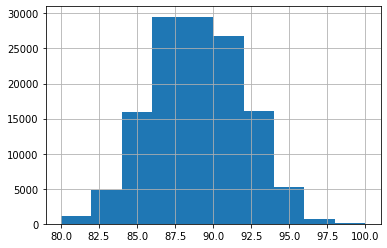

In [ ]:
fig = data['points'].hist()
plt.show()

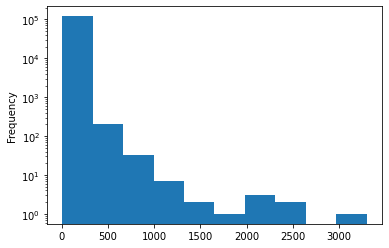

In [ ]:
fig = data['price'].plot(kind = 'hist', logy=True)
plt.show()

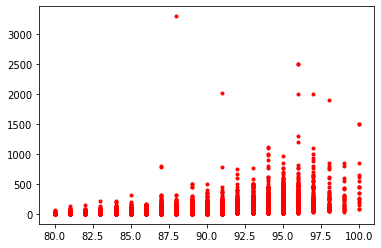

In [ ]:
plt.plot(data['points'], data['price'], 'r.')

In [ ]:
priceForPoint = data.groupby(by="points").mean()

In [ ]:
#PriceForPoint donne la moyenne du prix de la bouteille pour un nbr de point donné

[]

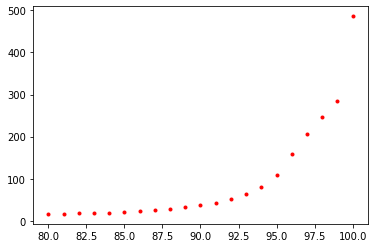

In [ ]:
plt.plot(priceForPoint.index, priceForPoint , 'r.')
plt.plot()

[]

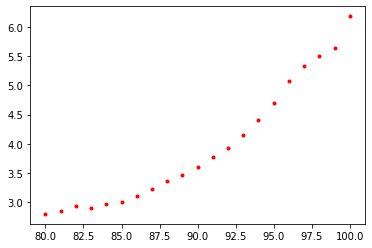

In [ ]:
plt.plot(priceForPoint.index, np.log(priceForPoint) , 'r.')
plt.plot()

In [ ]:
countries = data[ ["country", "winery"] ].groupby(by="country").count().sort_values(by="winery")[::-1]
countries.count()

winery    43
dtype: int64

In [ ]:
countries_price = data[ ["country", "price"]].groupby(by ="country").mean()

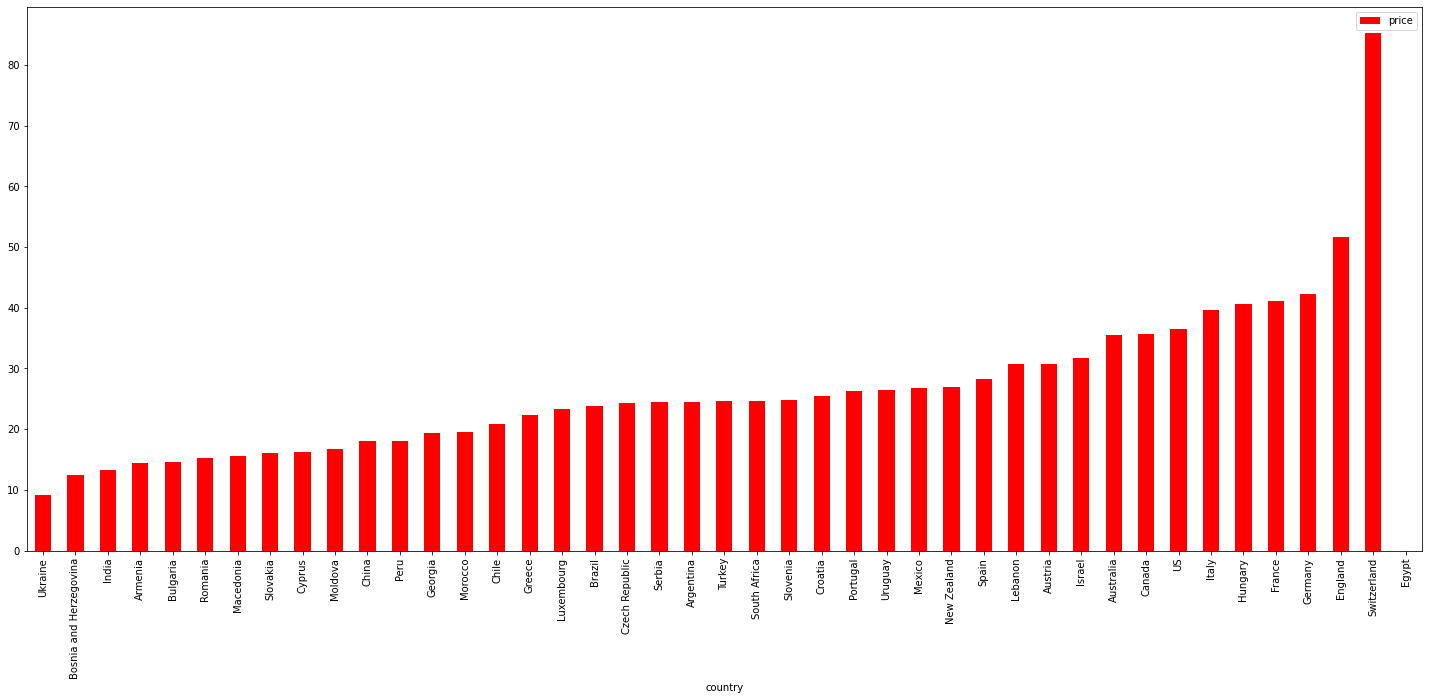

In [ ]:
countries_price.sort_values('price').plot(kind = "bar", figsize = (25,10), color = 'red')

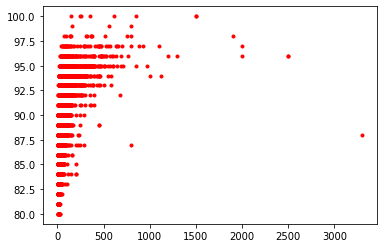

In [ ]:
dfr=data[data["country"] == 'France']
plt.plot(dfr['price'],dfr['points'], 'r.')

In [ ]:
dfr_max=dfr[dfr['price']> dfr['price'].quantile( q = 0.99)]

In [ ]:
dfr_max=dfr_max[['region_1','winery']]

In [ ]:
dfr_max.count()

region_1    172
winery      172
dtype: int64

In [ ]:
dfr_max_winery = dfr_max.groupby('region_1').count().sort_values(by="winery")[::-1]
dfr_max_winery.head()

,winery
region_1,
Champagne,22
Pessac-Léognan,13
Pauillac,12
Chevalier-Montrachet,11
Bâtard-Montrachet,10


# Partie 2 : Premier Modèle

## Modèle 1.1

In [8]:
data_10000 = data.sample(frac = 0.1, random_state = 1)
X = data_10000['description']
Y = data_10000['points']

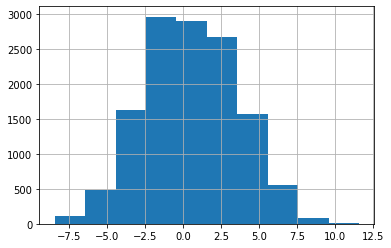

In [9]:
Y_corr= Y-Y.mean()
fig = Y_corr.hist()
plt.show()

In [10]:
#On va essayer de prédire, en fonction de la description, un score en séparant en 5 parties qui sera ensuite ramené sur 100.

In [12]:
groupe = (max(Y_corr)-min(Y_corr))/5
print("on va faire 5 catégories de taille", groupe+0.001)

on va faire 5 catégories de taille 4.001


In [13]:
Y_corr = np.array(Y_corr)
X = np.array(X)
mini = min(Y_corr)
for idx in range(len(Y_corr)):
    Y_corr[idx] = abs(Y_corr[idx] - mini)//4.001   

In [14]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y_corr,test_size=0.2)
Y_train = np.array(Y_train, dtype = int)

In [15]:
def sentence_to_avg(sentence, word_to_vec_map):
 
    # Step 1: Split sentence into list of lower case words (≈ 1 line)
    words = sentence.lower().split()

    # Initialize the average word vector, should have the same shape as your word vectors.
    avg = np.zeros(50)
    
    # Step 2: average the word vectors. You can loop over the words in the list "words".
    total = 0
    for w in words:
        while w not in word_to_vec_map.keys():
            if w[1:] in word_to_vec_map.keys():
                w = w[1:]
            else:
                w = w[:-1]
        total += word_to_vec_map[w]
    avg = total/len(words)
    
    
    return avg

In [16]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):

    m = Y.shape[0]                          # number of training examples
    n_y = 5                                 # number of classes  
    n_h = 50                                # dimensions of the GloVe vectors 
    
    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,)) 
    
    # Convert Y to Y_onehot with n_y classes
    Y_oh = convert_to_one_hot(Y) 
    
    # Optimization loop
    for t in range(num_iterations): # Loop over the number of iterations
        for i in range(m):          # Loop over the training examples
            
            # Average the word vectors of the words from the i'th training example
            avg = sentence_to_avg(X[i], word_to_vec_map)

            # Forward propagate the avg through the softmax layer
            z = np.dot(W,avg) + b
            a = softmax(z)

            # Compute cost using the i'th training label's one hot representation and "A" (the output of the softmax)
            cost = - np.dot(Y_oh[i],np.log(a))
            
            # Compute gradients 
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db
        
        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map)

    return pred, W, b

In [17]:
def predict(X, Y, W, b, word_to_vec_map):
    """
    Given X (sentences) and Y (emoji indices), predict emojis and compute the accuracy of your model over the given set.
    
    Arguments:
    X -- input data containing sentences, numpy array of shape (m, None)
    Y -- labels, containing index of the label emoji, numpy array of shape (m, 1)
    
    Returns:
    pred -- numpy array of shape (m, 1) with your predictions
    """
    m = X.shape[0]
    pred = np.zeros((m, 1))
    
    for j in range(m):                       # Loop over training examples
        
        # Split jth test example (sentence) into list of lower case words
        words = X[j].lower().split()
        
        # Average words' vectors
        avg = np.zeros((50,))
        for w in words:
            while w not in word_to_vec_map.keys():
                if w[1:] in word_to_vec_map.keys():
                    w = w[1:]
                else:
                    w = w[:-1]
            avg += word_to_vec_map[w]
        avg = avg/len(words)

        # Forward propagation
        Z = np.dot(W, avg) + b
        A = softmax(Z)
        pred[j] = np.argmax(A)
        
    print("Accuracy: "  + str(np.mean((pred[:] == Y.reshape(Y.shape[0],1)[:]))))
    
    return pred

In [18]:
pred, W, b = model(X_train, Y_train, word_to_vec_map)

Epoch: 0 --- cost = 0.6322023401767074
Accuracy: 0.5024526305665096
Epoch: 100 --- cost = 0.45602008366218544
Accuracy: 0.5465037991728383
Epoch: 200 --- cost = 0.46133847137813977
Accuracy: 0.5473694334904299
Epoch: 300 --- cost = 0.4649444939868927
Accuracy: 0.5471770703087429


In [19]:
print("Training set:")
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)

Training set:
Accuracy: 0.5480427046263345
Test set:
Accuracy: 0.5434615384615384


In [ ]:
#On se retrouve avec une accuracy de 50... ce qui est mieux que le hasard (5 catégories) mais pas encore optimal
#On va utiliser un algo de LTSM pour pouvoir cette fois ci prendre en compte l'ordre des éléments dans la phrase

In [20]:
X_my_sentences = np.array(["I love that wine, it is so tasteful. A great success to see in the future"])
Y_my_labels = np.array([[3]])
pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
pred

Accuracy: 1.0


array([[3.]])

In [21]:
#Regardons à partir d'une matrice de confusion ce qui pose problème

In [22]:
def plot_confusion_matrix(y_actu, y_pred, title='Confusion matrix', cmap=plt.cm.gray_r):
    
    df_confusion = pd.crosstab(y_actu, y_pred.reshape(y_pred.shape[0],), rownames=['Actual'], colnames=['Predicted'], margins=True)
    
    df_conf_norm = df_confusion / df_confusion.sum(axis=1)
    
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

Predicted  0.0   1.0   2.0  3.0   All
Actual                               
0.0         48   153    28    0   229
1.0         25   712   388    5  1130
2.0          2   324   636   16   978
3.0          0    33   207   17   257
4.0          0     1     5    0     6
All         75  1223  1264   38  2600


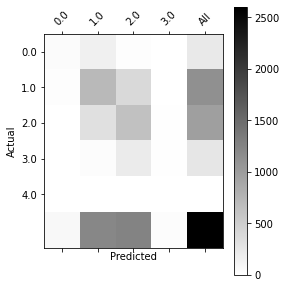

In [23]:
print(pd.crosstab(Y_test, pred_test.reshape(Y_test.shape), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

## Modèle 1.2

Jusque là on a évité le problème: en séparant en 5 classes de même taille, on a pas autant de chances de se retrouver dans chacune des cases... Pour être plus juste, on sépare les classes en fonctions des quantiles et on reteste le modèle à partir de ça

In [24]:
quant = Y.quantile([0.2,0.4,0.6,0.8,1])

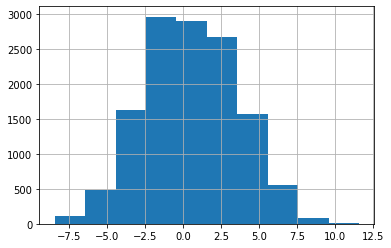

In [25]:
data_1000 = data.sample(frac = 0.1, random_state = 1)
X = data_1000['description']
Y = data_1000['points']

Y_corr= Y-Y.mean()
quant = quant - Y.mean()
fig = Y_corr.hist()
plt.show()

Y_corr = np.array(Y_corr)
for idx in range(len(Y_corr)):
    if Y_corr[idx] <= quant[0.2]:
        Y_corr[idx] = 0
    elif Y_corr[idx] <= quant[0.4]:
        Y_corr[idx] = 1
    elif Y_corr[idx] <= quant[0.6]:
        Y_corr[idx] = 2
    elif Y_corr[idx] <= quant[0.8]:
        Y_corr[idx] = 3
    else:
        Y_corr[idx] = 4

In [26]:
X = np.array(X)
Y_corr = np.array(Y_corr, dtype=int)
X_train,X_test,Y_train,Y_test=train_test_split(X,Y_corr,test_size=0.2)


In [ ]:
pred, W_1, b_1 = model(X_train, Y_train, word_to_vec_map)

Epoch: 0 --- cost = 1.8426313577493074
Accuracy: 0.3509666249879773
Epoch: 100 --- cost = 1.6731341198413348
Accuracy: 0.41665865153409637
Epoch: 200 --- cost = 1.6856811100887492
Accuracy: 0.4169471963066269
Epoch: 300 --- cost = 1.699977062557159
Accuracy: 0.41656246994325286


In [ ]:
print("Training set:")
pred_train = predict(X_train, Y_train, W_1, b_1, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W_1, b_1, word_to_vec_map)


In [ ]:
print(pd.crosstab(Y_test, pred_test.reshape(Y_test.shape), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

In [ ]:
#Mieux que le hasard certes mais toujours pas fou, on va tenter le LSTM

# Partie 3 : Modèle LSTM

In [8]:
import numpy as np
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform

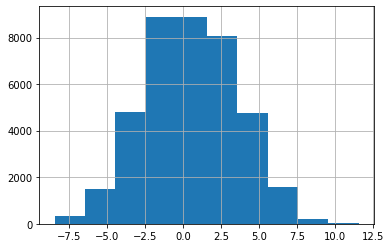

In [9]:
data_10000 = data.sample(frac = 0.3, random_state = 1)
data_10000 = data_10000.sort_values(by=['points'])
X_LTSM = data_10000['description']
Y = data_10000['points']
Y_corr= (Y-Y.mean())
quant = Y.quantile([0.2,0.4,0.6,0.8,1])
quant = quant - Y.mean()
fig = Y_corr.hist()
plt.show()

X_LTSM = np.array(X_LTSM)
Y_corr = np.array(Y_corr)

size =[]
for i in range(len(X_LTSM)):
  size.append(len(X_LTSM[i].split()))
size = np.array(size)

mask = np.ones(len(X_LTSM), dtype=bool)
for i in range(len(X_LTSM)):
  if len(X_LTSM[i].split())>np.quantile(size,0.99):
    mask[i] = False
X_LTSM = X_LTSM[mask]
Y_corr = Y_corr[mask] 


for idx in range(len(Y_corr)):
    if Y_corr[idx] <= quant[0.2] and np.sum(Y_corr ==0) < len(Y_corr)/5:
        Y_corr[idx] = 0
    elif Y_corr[idx] <= quant[0.4] and np.sum(Y_corr == 1) < len(Y_corr)/5:
        Y_corr[idx] = 1
    elif Y_corr[idx] <= quant[0.6] and np.sum(Y_corr == 2) < len(Y_corr)/5:
        Y_corr[idx] = 2
    elif Y_corr[idx] <= quant[0.8] and np.sum(Y_corr == 3) < len(Y_corr)/5:
        Y_corr[idx] = 3
    else:
        Y_corr[idx] = 4


In [10]:
size = size[mask]
size.max()

71

In [11]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):                               # loop over training examples
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = X[i].lower().split()
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
          while w not in word_to_vec_map.keys():
                if w[1:] in word_to_vec_map.keys():
                    w = w[1:]
                else:
                    w = w[:-1]
            # Set the (i,j)th entry of X_indices to the index of the correct word.
          X_indices[i, j] = word_to_index[w]
          j += 1
            
    
    return X_indices

In [12]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    # Step 1
    # Initialize the embedding matrix as a numpy array of zeros.
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Step 2
    # Set each row "idx" of the embedding matrix to be 
    # the word vector representation of the idx'th word of the vocabulary
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    # Step 3
    # Define Keras embedding layer with the correct input and output sizes
    # Make it non-trainable.
    embedding_layer = Embedding(vocab_len, emb_dim, trainable = True)

    # Step 4 (already done for you; please do not modify)
    # Build the embedding layer, it is required before setting the weights of the embedding layer. 
    embedding_layer.build((None,)) 
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [13]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][3] =", embedding_layer.get_weights()[0][1][3])

weights[0][1][3] = -0.3403


In [17]:
def Wine_model(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the graph.
    # It should be of shape input_shape and dtype 'int32' (as it contains indices, which are integers).
    sentence_indices = Input(input_shape, dtype= 'int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer
    # (See additional hints in the instructions).
    embeddings = embedding_layer(sentence_indices)
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = LSTM(128, return_sequences=True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(128, return_sequences=False)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X through a Dense layer with 5 units
    X = Dense( units = 5)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices, outputs=X)
    
    return model

In [95]:
model = Wine_model((size.max(),), word_to_vec_map, word_to_index)
model.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 71)]              0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 71, 50)            20000000  
_________________________________________________________________
lstm_16 (LSTM)               (None, 71, 128)           91648     
_________________________________________________________________
dropout_18 (Dropout)         (None, 71, 128)           0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 5)               

In [96]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [97]:
Y_corr = np.array(Y_corr, dtype=int)
X_train,X_test,Y_train,Y_test=train_test_split(X_LTSM,Y_corr,test_size=0.2)

In [98]:
X_train_indices = sentences_to_indices(X_train, word_to_index, size.max())
Y_train_oh = convert_to_one_hot(Y_train)

In [102]:
model.fit(X_train_indices, Y_train_oh, epochs = 10, batch_size = 1500, shuffle=True)

Epoch 1/10
21/21 [==============================] - 5s 248ms/step - loss: 1.0557 - accuracy: 0.5338
Epoch 2/10
21/21 [==============================] - 5s 249ms/step - loss: 1.0231 - accuracy: 0.5492
Epoch 3/10
21/21 [==============================] - 5s 250ms/step - loss: 1.0008 - accuracy: 0.5577
Epoch 4/10
21/21 [==============================] - 5s 250ms/step - loss: 0.9775 - accuracy: 0.5746
Epoch 5/10
21/21 [==============================] - 5s 241ms/step - loss: 0.9564 - accuracy: 0.5875
Epoch 6/10
21/21 [==============================] - 5s 247ms/step - loss: 0.9381 - accuracy: 0.5977
Epoch 7/10
21/21 [==============================] - 5s 249ms/step - loss: 0.9489 - accuracy: 0.5909
Epoch 8/10
21/21 [==============================] - 5s 243ms/step - loss: 0.9246 - accuracy: 0.6055
Epoch 9/10
21/21 [==============================] - 5s 241ms/step - loss: 0.9007 - accuracy: 0.6195
Epoch 10/10
21/21 [==============================] - 5s 244ms/step - loss: 0.8616 - accuracy: 0.6446

In [103]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = size.max())
Y_test_oh = convert_to_one_hot(Y_test)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
pred = model.predict(X_test_indices)
pred = np.argmax(pred, axis = 1) 
print()
print("Test accuracy = ", acc)

242/242 [==============================] - 1s 6ms/step - loss: 1.3070 - accuracy: 0.4775

Test accuracy =  0.47749030590057373


Predicted     0     1     2     3     4   All
Actual                                       
0          1120   339    89     8     2  1558
1           544   659   251    79     8  1541
2           171   524   532   252    60  1539
3            32   220   495   538   313  1598
4             4    67   183   398   842  1494
All        1871  1809  1550  1275  1225  7730


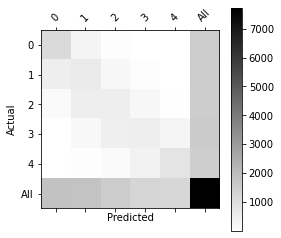

In [104]:
print(pd.crosstab(Y_test, pred.reshape(Y_test.shape), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred)

 # Partie 4: Le retour du modèle 1

In [ ]:
def sentence_to_avg(sentence, word_to_vec_map):
 
    # Step 1: Split sentence into list of lower case words (≈ 1 line)
    words = sentence.lower().split()

    # Initialize the average word vector, should have the same shape as your word vectors.
    avg = np.zeros(50)
    
    # Step 2: average the word vectors. You can loop over the words in the list "words".
    total = 0
    for w in words:
        while w not in word_to_vec_map.keys():
            if w[1:] in word_to_vec_map.keys():
                w = w[1:]
            else:
                w = w[:-1]
        total += word_to_vec_map[w]
    avg = total/len(words)
    
    
    return avg

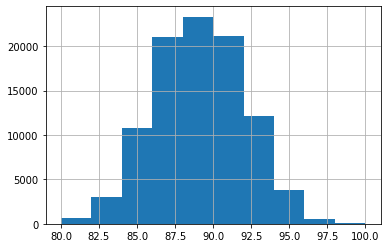

In [ ]:
data_1000 = data[['description', 'points', 'price', 'taster_name']].sample(frac = 1, random_state = 1)
data_1000 = data_1000.dropna()
X = data_1000['description']
Y = data_1000['points']
Y = Y
prices = data_1000['price']

fig = Y.hist()
plt.show()

Y = np.array(Y)
m=len(X)

X = np.array(X)
X_emb = np.zeros((m,50)) 
prices = np.array(prices)
prices = np.log(prices)
prices = prices - prices.mean()
#taster = testeur(data_1000)/18
for i in range(m): 
  X_emb[i] = sentence_to_avg(X[i], word_to_vec_map)
X_emb = np.column_stack((X_emb,prices))
#X_emb = np.column_stack((X_emb,taster))
Y = np.array(Y, dtype=int)
X_train,X_test,Y_train,Y_test=train_test_split(X_emb,Y,test_size=0.2)

In [ ]:
def relu(x):
    """Compute softmax values for each sets of scores in x."""
    if x <0:
      x = 0
    return x

In [ ]:
def model_4(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):

    m = Y.shape[0]                          # number of training examples
    n_y = 1                                 # number of classes  
    n_h = 51                               # dimensions of the GloVe vectors + 1
    
    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,)) 
    
    
    # Optimization loop
    for t in range(num_iterations): # Loop over the number of iterations
        for i in range(m):          # Loop over the training examples
          
            # Forward propagate the avg through the softmax layer
            z = np.dot(W,X[i]) + b
            
            a = relu(z)
            
            # Compute cost using the i'th training label's one hot representation and "A" (the output of the softmax)
            
            # Compute gradients 
            dz = a - Y[i]
            dW = np.dot(dz.reshape(n_y,1), X[i].reshape(1, n_h))
            db = dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db
        
        if t % 100 == 0:
            print("Epoch: " + str(t))
            pred = predict_4(X, Y, W, b, word_to_vec_map)

    return pred, W, b

In [ ]:
def predict_4(X, Y, W, b, word_to_vec_map):
    """
    Given X (sentences) and Y (emoji indices), predict emojis and compute the accuracy of your model over the given set.
    
    Arguments:
    X -- input data containing sentences, numpy array of shape (m, None)
    Y -- labels, containing index of the label emoji, numpy array of shape (m, 1)
    
    Returns:
    pred -- numpy array of shape (m, 1) with your predictions
    """
    m = X.shape[0]
    pred = np.zeros(m)
    
    for j in range(m):                       # Loop over training examples
        
        # Forward propagation
        Z = np.dot(W, X[j]) + b
        A = relu(Z)
        pred[j] = A[0]
        
    print("Accuracy: "  + str(np.square(np.subtract(Y,pred)).mean() ))
    
    return pred

In [ ]:
pred, W_4, b_4 = model_4(X_train, Y_train, word_to_vec_map)
print(pred)

Epoch: 0
Accuracy: 5.157476464924126
Epoch: 100
Accuracy: 4.450830774806901
Epoch: 200
Accuracy: 4.450982237596474
Epoch: 300
Accuracy: 4.450990823271798
Epoch: 400
Accuracy: 4.450991497683144
Epoch: 500
Accuracy: 4.45099160269804
Epoch: 600
Accuracy: 4.45099161985956
Epoch: 700
Accuracy: 4.450991622379849
[85.69309962 91.93536189 90.20496968 ... 86.05388037 89.96704993
 87.84834505]


In [ ]:
print("Training set:")
pred_train = predict_4(X_train, Y_train, W_4, b_4, word_to_vec_map)
print('Test set:')
pred_test = predict_4(X_test, Y_test, W_4, b_4, word_to_vec_map)

Training set:
Accuracy: 4.450991622717817
Test set:
Accuracy: 4.4537626016700775


In [ ]:
ecart = []
for i in range(0,len(Y_test)):
 ecart.append(abs(pred_test[i] - Y_test[i]))
ecart = np.array(ecart)
print(np.max(ecart), ecart.mean(), ecart.var())
print(np.quantile(ecart, [0.1,0.9]))

10.372858700730234 1.661618870254965 1.6927853316826909
[0.26074194 3.42299071]


Predicted   0.0   1.0   2.0   3.0   4.0    All
Actual                                        
0          2481  1251   620   275    74   4701
1          1087  1492  1323   821   306   5029
2           194   496   592   509   245   2036
3            94   557  1025  1407  1152   4235
4             4    63   299   847  2082   3295
All        3860  3859  3859  3859  3859  19296


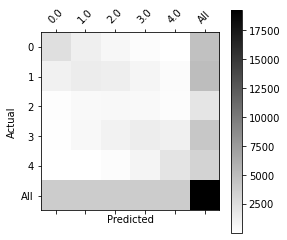

In [ ]:
Y_test = pd.Series(Y_test)
quant = Y_test.quantile([0.2,0.4,0.6,0.8,1])
Y_res = np.array(Y_test)

for idx in range(len(Y_test)):
    if Y_res[idx] <= quant[0.2]:
        Y_res[idx] = 0
    elif Y_res[idx] <= quant[0.4]:
        Y_res[idx] = 1
    elif Y_res[idx] <= quant[0.6]:
        Y_res[idx] = 2
    elif Y_res[idx] <= quant[0.8]:
        Y_res[idx] = 3
    else:
        Y_res[idx] = 4

pred_test= pd.Series(pred_test)
quant_pred = pred_test.quantile([0.2,0.4,0.6,0.8,1])
pred_res = np.array(pred_test)

for idx in range(len(Y_test)):
    if pred_res[idx] <= quant_pred[0.2]:
        pred_res[idx] = 0
    elif pred_res[idx] <= quant_pred[0.4]:
        pred_res[idx] = 1
    elif pred_res[idx] <= quant_pred[0.6]:
        pred_res[idx] = 2
    elif pred_res[idx] <= quant_pred[0.8]:
        pred_res[idx] = 3
    else:
        pred_res[idx] = 4

print(pd.crosstab(Y_res, pred_res.reshape(Y_test.shape), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_res, pred_res)


In [ ]:
str('Accuracy: ' + str(np.mean(pred_res[:] == Y_res[:]) ) )

'Accuracy: 0.4173922056384743'

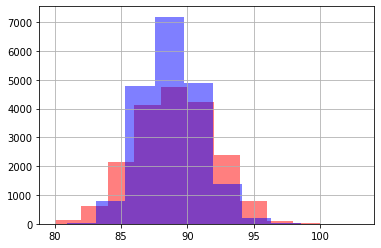

In [ ]:
fig1 = Y_test.hist(alpha = 0.5, color = 'r')
fig2 = pred_test.hist(alpha = 0.5, color = 'b')

plt.show()

# Partie 5 : Retour sur LSTM

Nous avons vu Partie 3 que le modèle LSTM sous forme de classe ne fonctionner pas parfaitement. On va donc cette fois chercher à avoir en output directement le score.
La seule chose qui change réellement, c'est la tête de la fonction de perte.

In [153]:
import numpy as np
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform

In [154]:
data_10000 = data.sample(frac = 0.3, random_state = 1)
X_LTSM = data_10000['description']
Y_LTSM = data_10000['points']

print(len(X_LTSM))

X_LTSM = np.array(X_LTSM)
Y_LTSM = np.array(Y_LTSM)

size =[]
for i in range(len(X_LTSM)):
  size.append(len(X_LTSM[i].split()))
size = np.array(size)

mask = np.ones(len(X_LTSM), dtype=bool)
for i in range(len(X_LTSM)):
  if len(X_LTSM[i].split())>np.quantile(size,0.99):
    mask[i] = False
X_LTSM = X_LTSM[mask]
Y_LTSM = Y_LTSM[mask] 
size = size[mask] 

min_Y = Y_LTSM.min()
max_Y = Y_LTSM.max()
Y_LTSM = (Y_LTSM - min_Y)/(max_Y - min_Y)



38991


38991


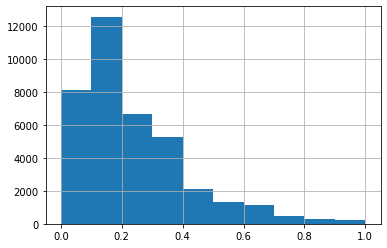

In [81]:
#Run it just if you want to predict the price (instead of the above cellul):
data_10000 = data.sample(frac = 0.3, random_state = 1)
X_LTSM = data_10000['description']
Y_LTSM = data_10000['price']
Y_LTSM = Y_LTSM.fillna(method='backfill')

print(len(X_LTSM))

X_LTSM = np.array(X_LTSM)
Y_LTSM = np.array(Y_LTSM)

mask1 = np.ones(len(Y_LTSM), dtype=bool)
for i in range(len(X_LTSM)):
  if Y_LTSM[i] >np.quantile(Y_LTSM,0.98):
    mask1[i] = False
X_LTSM = X_LTSM[mask1]
Y_LTSM = Y_LTSM[mask1]

size =[]
for i in range(len(X_LTSM)):
  size.append(len(X_LTSM[i].split()))
size = np.array(size)

mask2 = np.ones(len(X_LTSM), dtype=bool)
for i in range(len(X_LTSM)):
  if len(X_LTSM[i].split())>np.quantile(size,0.999):
    mask2[i] = False
X_LTSM = X_LTSM[mask2]
Y_LTSM = Y_LTSM[mask2] 

min_Y = Y_LTSM.min()
max_Y = Y_LTSM.max()
Y_LTSM = (Y_LTSM - min_Y)/(max_Y - min_Y)
size = size[mask2]
size.max()
pd.Series(Y_LTSM).hist()
plt.show()

In [112]:
X_train,X_test,Y_train,Y_test=train_test_split(X_LTSM,Y_LTSM,test_size=0.2)
X_train_indices = sentences_to_indices(X_train, word_to_index, size.max())

In [113]:
def Wine_model_2(input_shape, word_to_vec_map, word_to_index):
    """
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    sentence_indices = Input(input_shape, dtype= 'int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer
    embeddings = embedding_layer(sentence_indices)
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    X = LSTM(128, return_sequences= True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    X = LSTM(128, return_sequences= False)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    X = Dense ( units = 128 )(X)
    X = Activation('relu')(X)
    X = Dropout(0.5)(X)
    X = Dense( units = 1 )(X)
    X = Activation('linear')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices, outputs=X)
    
    return model

In [114]:
model_2 = Wine_model_2((size.max(),), word_to_vec_map, word_to_index)
model_2.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 71)]              0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 71, 50)            20000000  
_________________________________________________________________
lstm_14 (LSTM)               (None, 71, 128)           91648     
_________________________________________________________________
dropout_21 (Dropout)         (None, 71, 128)           0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)             

In [46]:
# Compute that to load a model : 

from keras.models import model_from_json
from keras.models import load_model


json_file = open('/content/drive/My Drive/Wine_project/model_num.json', 'r')
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
# load weights into new model
model_2.load_weights("/content/drive/My Drive/Wine_project/model_num.h5")
print("Loaded model from disk")
model_2.save('/content/drive/My Drive/Wine_project/model_num.hdf5')
model_2=load_model('/content/drive/My Drive/Wine_project/model_num.hdf5')
model_2.compile(optimizer = 'adam', loss= 'mean_squared_error') 


X_test_indices = sentences_to_indices(X_test, word_to_index, size.max())
loss = model.evaluate(X_test_indices, Y_test)

ValueError: ignored

In [115]:
from keras import metrics
model_2.compile(loss='mean_squared_error', optimizer='adam', metrics= [metrics.mean_squared_error, 
                       metrics.mean_absolute_error])

In [157]:
model_2.fit(X_train_indices, Y_train, epochs = 5, batch_size = 1500, shuffle=True)

Epoch 1/5
21/21 [==============================] - 5s 242ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0711
Epoch 2/5
21/21 [==============================] - 5s 243ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0715
Epoch 3/5
21/21 [==============================] - 5s 238ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0701
Epoch 4/5
21/21 [==============================] - 5s 241ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0680
Epoch 5/5
21/21 [==============================] - 5s 239ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0683


In [158]:
X_test_indices = sentences_to_indices(X_test, word_to_index, size.max())
loss, mse, mae = model_2.evaluate(X_test_indices, Y_test)
pred = model_2.predict(X_test_indices)

242/242 [==============================] - 1s 6ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0680


In [27]:
from keras.models import model_from_json
from keras.models import load_model
model_json = model.to_json()
with open("/content/drive/My Drive/Wine_project/nawak.json", "w") as json_file:
  json_file.write(model_json)
model.save_weights("/content/drive/My Drive/Wine_project/nawak.hdf5")

NameError: ignored

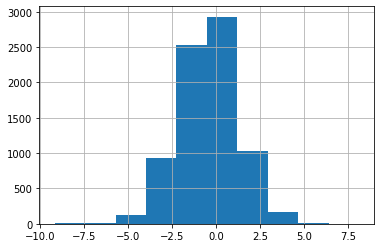

In [159]:
pred_post,Y_test_post = pred*(max_Y - min_Y) + min_Y,Y_test*(max_Y - min_Y) + min_Y
pred_post = np.reshape(pred_post,(len(pred)))
ecart = pred_post - Y_test_post
pd.Series(ecart).hist()
plt.show()

In [161]:
np.quantile(ecart, 0.90)

1.6705192565917972

In [138]:
#petit test aléatoire:
i = rd.randint(0,len(pred_post))
print("Prédiction:" + str(pred_post[i]))
print("Réel :" +str(Y_test_post[i]))

Prédiction:89.92085
Réel :91.0


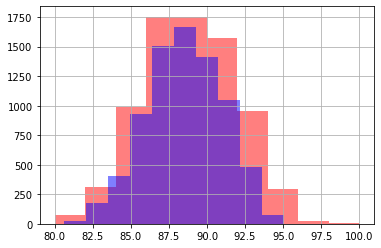

In [139]:
fig1 = pd.Series(Y_test_post).hist(alpha = 0.5, color = 'r')
fig2 = pd.Series(pred_post).hist(alpha = 0.5, color = 'b')

plt.show()

In [155]:
def predict_wine_score(sentence):
  #sentence MUST BE a string, it is the sentence describing the wine 
  #return the score (out of 100) predicted for the bottle described
  sentence = np.array([sentence])
  sentence = sentences_to_indices(sentence,word_to_index, size.max())
  return model_2.predict(sentence)[0][0]*(max_Y - min_Y) + min_Y

In [166]:
#Petit exemple avec ce vin 
#https://www.vivino.com/FR/fr/sainte-marguerite-symphonie-cotes-de-provence-rouge/w/3496774?year=2018&price_id=22596529&cart_item_source=nav-explore
#noté 4.3/5 ce qui équivaut à 86/100

predict_wine_score("After the white, the red. Wine with a nice roundness, a nice spicy and fleshy side. It is powerful and subtle at the same time. It's organic and it's all good. One of my reference domains in Côtes de Provence.")

86.099613904953

# Conclusion


Le modèle donne déjà des résultats très convaincants!
Cependant il existe encore de nombreuses pistes d'améliorations...
On pourrait se servir du prix pour mieux déterminer le score ou du score pour mieux déterminer le prix.
Il est également possible de prendre en compte l'auteur de la critique pour améliorer la prédiction.

Un autre problème du modèle et la difficulté qu'il a à prédire les prix extremes. Si nous nous intéressons à des bouteilles de très hautes qualité il devient rapidement inutile.

Globalement, ce modèle s'adresse à des acheteurs lambda qui doivent se forger rapidement une opinion d'une bouteille à partir d'une descrpition succinte.